In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_validate

#  from pyspark.sql import SparkSession

import warnings
warnings.filterwarnings('ignore')

['Female' 'Male' 'Other']
gender                 18
age                    18
hypertension           18
heart_disease          18
smoking_history        18
bmi                    18
HbA1c_level            18
blood_glucose_level    18
diabetes               18
dtype: int64


<Axes: >

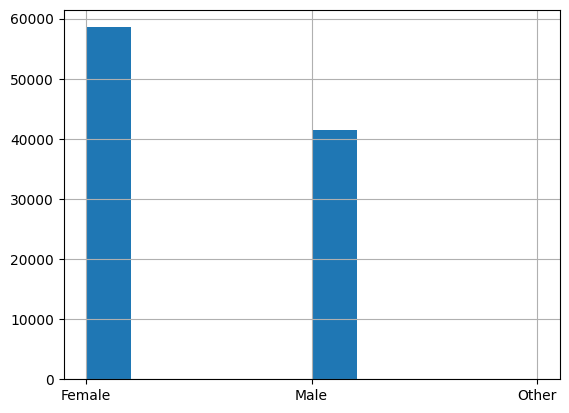

In [2]:
# df = pd.read_csv('/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv')
df = pd.read_csv('./data/diabetes_prediction.csv')
df

print(df['gender'].unique())
print(df[df['gender'] == 'Other'].count())
df['gender'].hist()


In [3]:
colmn = df.columns
print(colmn)

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes'],
      dtype='object')


In [4]:
# Let's Encod data
encoder = LabelEncoder()
colmn = df.columns
for index, name in enumerate(colmn):
    df[name] = encoder.fit_transform(df[name].values)

#  df.corr()


<Axes: >

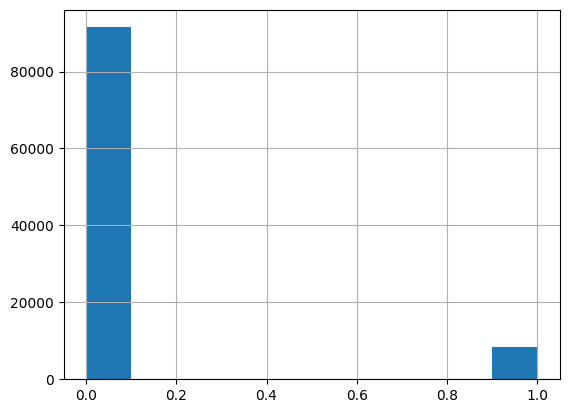

In [5]:
df['diabetes'].hist()

# Disbalance in classes (

In [6]:
# there are literli function plot_tree to visualize that

X = df.drop(columns='diabetes')
y = pd.DataFrame(df['diabetes'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Fit the classifier with default hyper-parameters
clf = DecisionTreeClassifier(max_depth=8)
model = clf.fit(X, y)

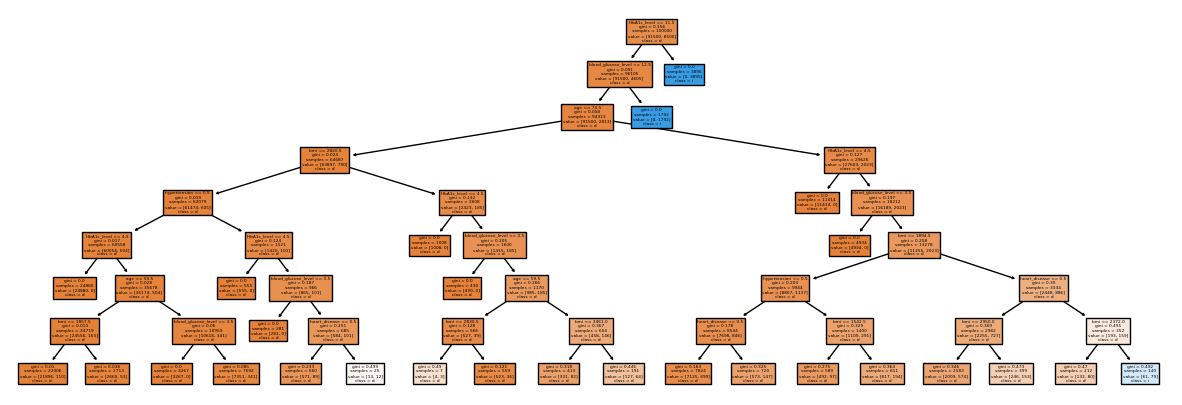

In [7]:
fig = plt.figure(figsize=(15, 5))
_ = tree.plot_tree(clf, 
                   feature_names=X.columns,  
                   class_names='diabetes',
                   filled=True)

Confusion matrix, without normalization
[[30200    16]
 [  907  1877]]


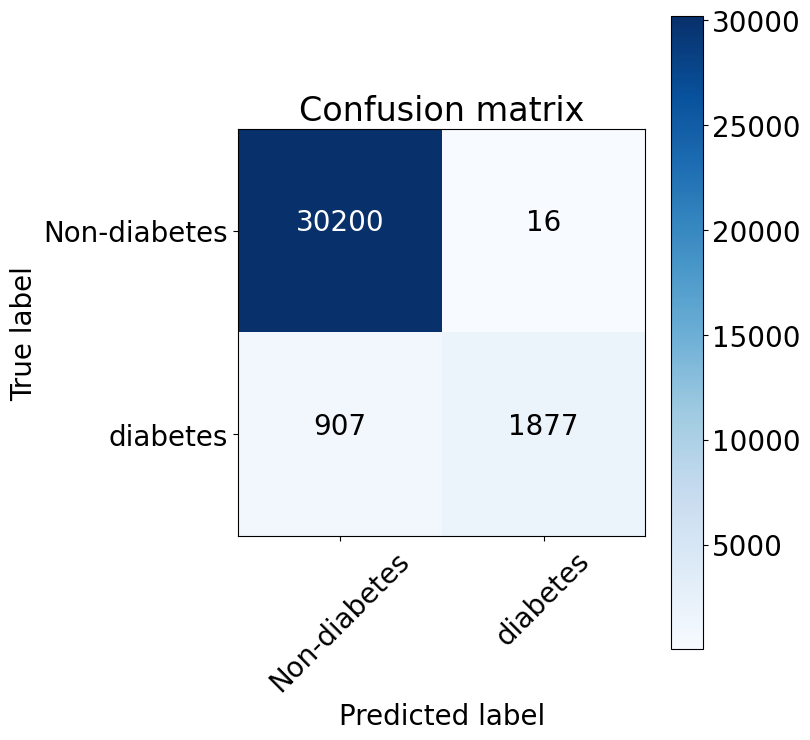

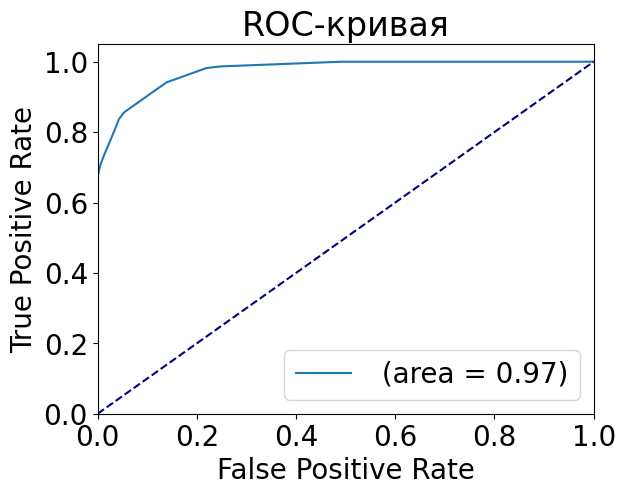

In [8]:
from sklearn.metrics import confusion_matrix
import itertools

pred_rt = model.predict(X_test)

accuracy_score(y_test, pred_rt)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

font = {'size' : 20}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, model.predict(X_test))
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-diabetes', 'diabetes'],
                      title='Confusion matrix')
plt.show()


# Roc curve
pred_rt = model.predict_proba(X_test)[:, 1]
fpr, tpr, treshold = roc_curve(y_test, pred_rt)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr,
            label=f' (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC-кривая')
plt.legend(loc="lower right")

In [9]:
report = classification_report(y_test, model.predict(X_test), target_names=['Non-diabetes', 'diabetes'])
print(report)

              precision    recall  f1-score   support

Non-diabetes       0.97      1.00      0.98     30216
    diabetes       0.99      0.67      0.80      2784

    accuracy                           0.97     33000
   macro avg       0.98      0.84      0.89     33000
weighted avg       0.97      0.97      0.97     33000



<h4>Gradient boost</h4>

In [10]:
params = {'n_estimators':200,
          'max_depth':12,
          'criterion':'squared_error',
          'learning_rate':0.03,
          'min_samples_leaf':16,
          'min_samples_split':16
          }

gbr = GradientBoostingClassifier(**params)
gbr.fit(X_train, y_train)

pred_grd = gbr.predict_proba(X_test)[:, 1]

Confusion matrix, without normalization
[[30140    76]
 [  869  1915]]


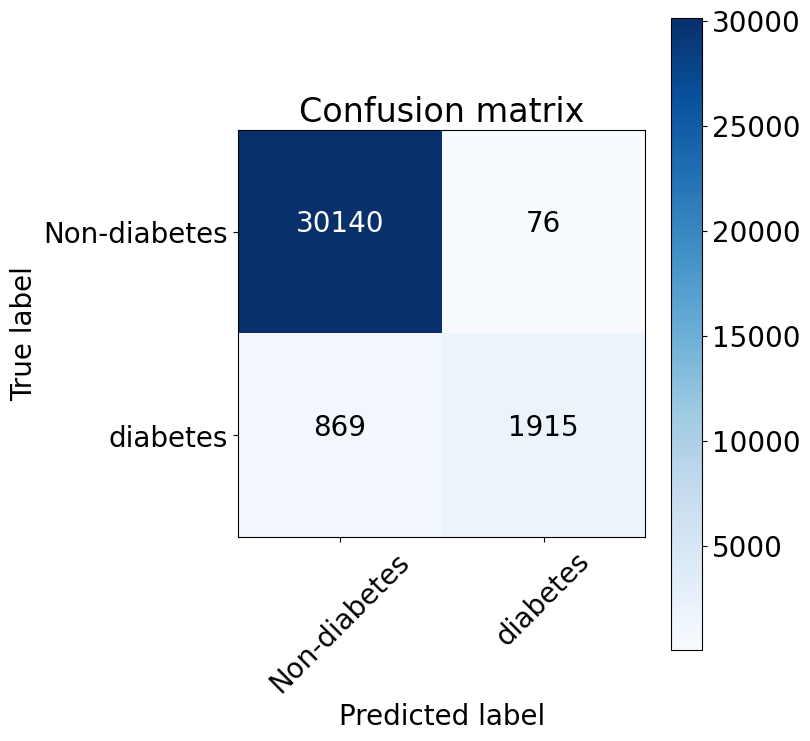

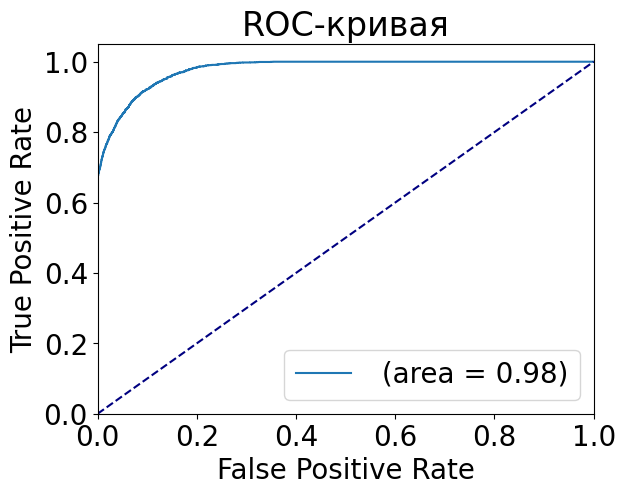

In [11]:
font = {'size' : 20}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, gbr.predict(X_test))
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-diabetes', 'diabetes'],
                      title='Confusion matrix')
plt.show()

fpr, tpr, treshold = roc_curve(y_test, pred_grd)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr,
            label=f' (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC-кривая')
plt.legend(loc="lower right")

In [12]:
report = classification_report(y_test, gbr.predict(X_test), target_names=['Non-diabetes', 'diabetes'])
print(report)

              precision    recall  f1-score   support

Non-diabetes       0.97      1.00      0.98     30216
    diabetes       0.96      0.69      0.80      2784

    accuracy                           0.97     33000
   macro avg       0.97      0.84      0.89     33000
weighted avg       0.97      0.97      0.97     33000



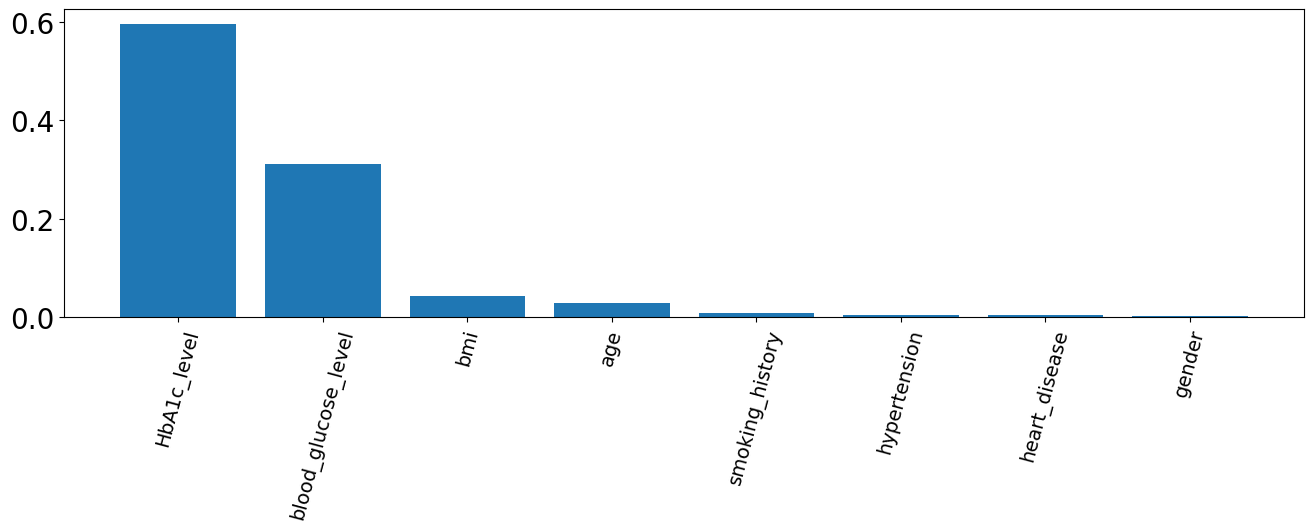

In [13]:
feature_importance = gbr.feature_importances_
feature_importance_dict = dict(zip(X_test.columns, feature_importance))
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

variables, importance = zip(*sorted_feature_importance)
fig = plt.figure(figsize=(16, 4))
plt.bar(variables, importance)
plt.xticks(fontsize=14,rotation=75)
plt.show()

<h3>Dependense in model</h3>

In [14]:
leath_nodes = np.array([i for i in range(2, 6000, 400)], dtype=np.int16)
train_score = np.array([0 for i in range(len(leath_nodes))], dtype=np.float32)
valid_score = np.array([0 for i in range(len(leath_nodes))], dtype=np.float32)

X_tr, X_ts, y_tr, y_ts = train_test_split(X, y, test_size=0.1, random_state=1)

#cv = StratifiedKFold(n_splits=5) # For validation

for index, leath in enumerate(leath_nodes):
    # I need to calculate score with most
    #trn_mn = []
    #vld_mn = []

    local_model = GradientBoostingClassifier(
            max_depth=5,
            criterion = 'squared_error',
            max_leaf_nodes = leath
        )
    cv_results = cross_validate(local_model, X_tr, y_tr, cv=3, return_estimator=True,
                                scoring='f1'
                                )
    print(f'{index + 1}. for {leath} of leaths cv_reesults is {cv_results["test_score"]} ', end='\n')
    valid_score[index] =  np.min(cv_results['test_score'])
    local_model.fit(X_tr, y_tr)
    train_score[index] = f1_score(y_tr, local_model.predict(X_tr))
print(valid_score)

1. for 2 of leaths cv_reesults is [0.80122468 0.79754311 0.80244591] 
2. for 402 of leaths cv_reesults is [0.80413793 0.80278422 0.8099097 ] 
3. for 802 of leaths cv_reesults is [0.80432283 0.80259801 0.80972222] 
4. for 1202 of leaths cv_reesults is [0.80432283 0.80278422 0.8099097 ] 
5. for 1602 of leaths cv_reesults is [0.80432283 0.80306193 0.80963409] 
6. for 2002 of leaths cv_reesults is [0.80413793 0.80259801 0.80953483] 
7. for 2402 of leaths cv_reesults is [0.80432283 0.80306193 0.80944663] 
8. for 2802 of leaths cv_reesults is [0.80413793 0.80278422 0.8099097 ] 
9. for 3202 of leaths cv_reesults is [0.80413793 0.8028757  0.80963409] 
10. for 3602 of leaths cv_reesults is [0.80432283 0.80259801 0.8099097 ] 
11. for 4002 of leaths cv_reesults is [0.80413793 0.80278422 0.8099097 ] 
12. for 4402 of leaths cv_reesults is [0.80413793 0.80278422 0.80963409] 
13. for 4802 of leaths cv_reesults is [0.80432283 0.80259801 0.80972222] 
14. for 5202 of leaths cv_reesults is [0.80404784 0.

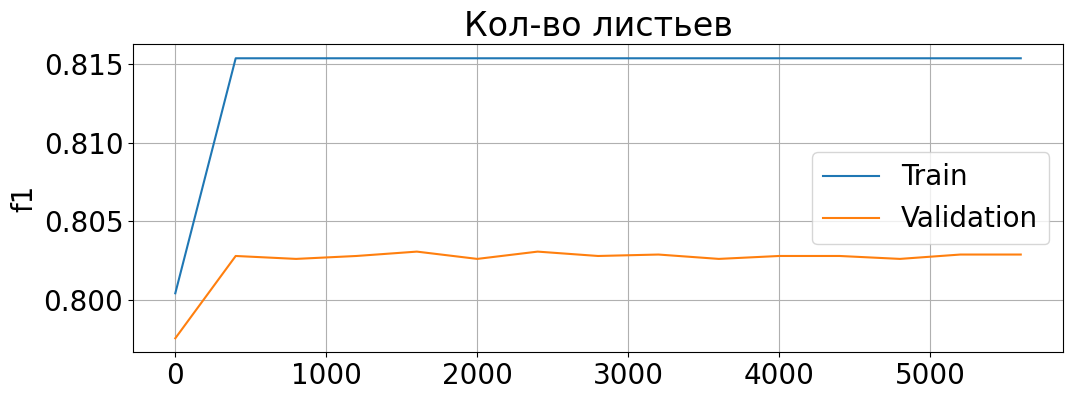

In [15]:
plt.figure(figsize=(12, 4))
plt.plot(leath_nodes, train_score, label='Train')
plt.plot(leath_nodes, valid_score, label='Validation')
plt.xlabel('')
plt.ylabel('f1')
plt.title('Кол-во листьев')
plt.grid(True)
plt.legend()
plt.show()

<h3>Dependense but with deep of model</h3>

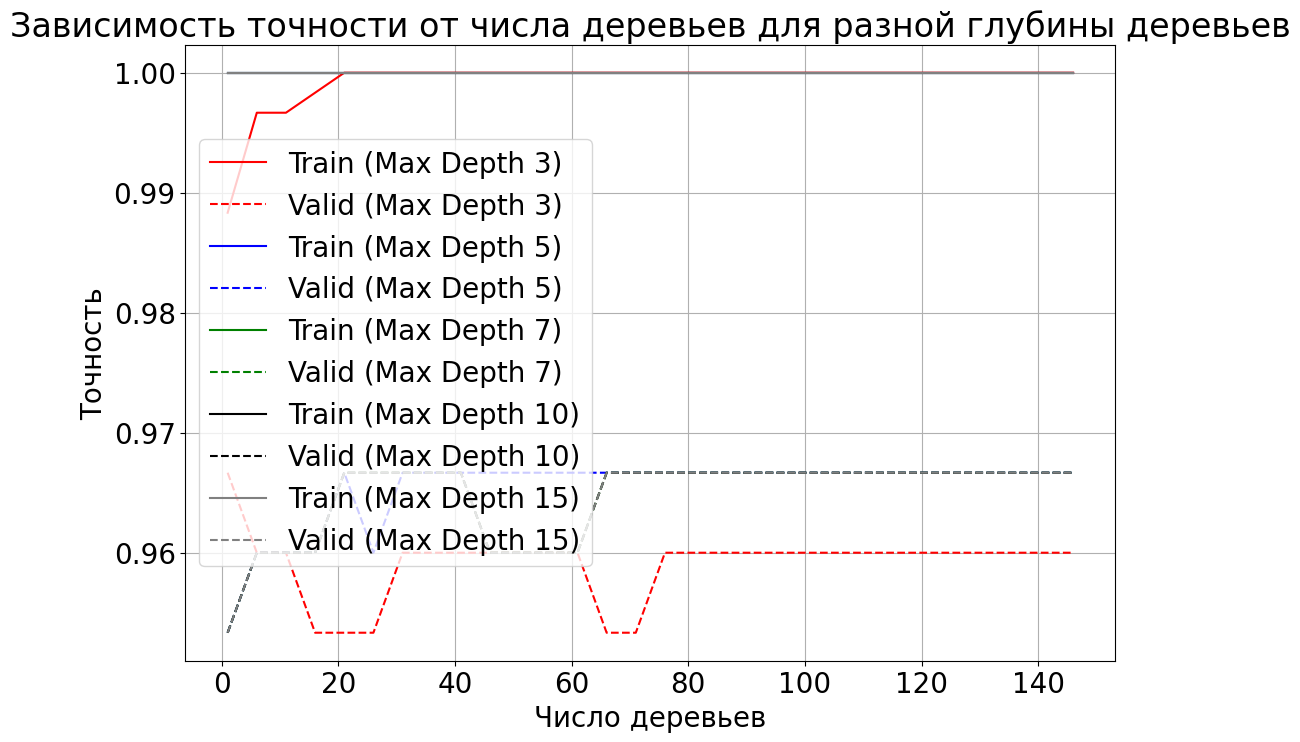

In [16]:
# dataset = datasets.load_wine()
from sklearn import datasets
cv = StratifiedKFold(n_splits=5)
dataset = datasets.load_iris()

xs = dataset.data
ys = dataset.target

xs_train, xs_test, ys_train, ys_test = train_test_split(xs, ys, test_size=0.2, random_state=42)

n_estimators_values = np.arange(1, 150, 5)
max_depth_values = [3, 5, 7, 10, 15]

colors = ['red', 'blue', 'green', 'black', 'grey']

train_scores = []
valid_scores = []

for max_depth in max_depth_values:
    train_scores_depth = []
    valid_scores_depth = []

    for n_estimators in n_estimators_values:
        train_sc = []
        valid_sc = []
        
        for train, test in cv.split(xs, ys):
            gb_model = GradientBoostingClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=42)
            gb_model.fit(xs[train], ys[train])

            pred_train = gb_model.predict(xs[train])
            pred_test  = gb_model.predict(xs[test])

            train_sc.append(accuracy_score(ys[train], pred_train))
            valid_sc.append(accuracy_score(ys[test], pred_test))
        
        train_scores_depth.append(np.mean(train_sc))
        valid_scores_depth.append(np.mean(valid_sc))
    
    train_scores.append(train_scores_depth)
    valid_scores.append(valid_scores_depth)

plt.figure(figsize=(12, 8))

for i, (max_depth, color) in enumerate(zip(max_depth_values, colors)):
    plt.plot(n_estimators_values, train_scores[i], label=f'Train (Max Depth {max_depth})', color=color)
    plt.plot(n_estimators_values, valid_scores[i], label=f'Valid (Max Depth {max_depth})', linestyle='dashed', color=color)

plt.xlabel('Число деревьев')
plt.ylabel('Точность')
plt.title('Зависимость точности от числа деревьев для разной глубины деревьев')
plt.grid(True)
plt.legend()
plt.show()

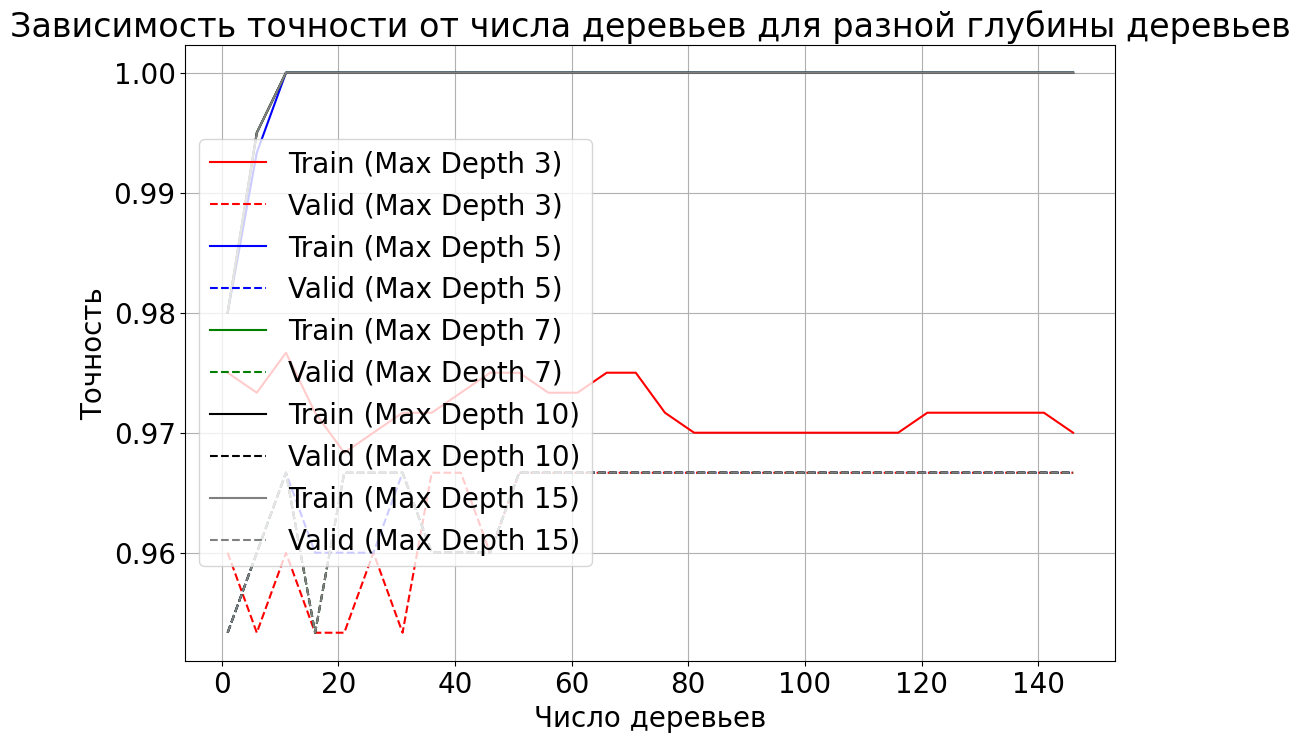

In [17]:
train_scores = []
valid_scores = []

for max_depth in max_depth_values:
    train_scores_depth = []
    valid_scores_depth = []

    for n_estimators in n_estimators_values:
        train_sc = []
        valid_sc = []

        for train, test in cv.split(xs, ys):
            gb_model = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, random_state=42)
            gb_model.fit(xs[train], ys[train])

            pred_train = gb_model.predict(xs[train])
            pred_test  = gb_model.predict(xs[test])

            train_sc.append(accuracy_score(ys[train], pred_train))
            valid_sc.append(accuracy_score(ys[test], pred_test))

        train_scores_depth.append(np.mean(train_sc))
        valid_scores_depth.append(np.mean(valid_sc))
    
    train_scores.append(train_scores_depth)
    valid_scores.append(valid_scores_depth)

plt.figure(figsize=(12, 8))

for i, (max_depth, color) in enumerate(zip(max_depth_values, colors)):
    plt.plot(n_estimators_values, train_scores[i], label=f'Train (Max Depth {max_depth})', color=color)
    plt.plot(n_estimators_values, valid_scores[i], label=f'Valid (Max Depth {max_depth})', linestyle='dashed', color=color)

plt.xlabel('Число деревьев')
plt.ylabel('Точность')
plt.title('Зависимость точности от числа деревьев для разной глубины деревьев')
plt.grid(True)
plt.legend()
plt.show()